## Target
- 1.Determine the recognition accuracy (percentage of correctly classified data points) of KNN classifier on K=1,3,5
- 2.Determine the overall run time for computing the 1-nearest neighbor of every data in data2-test.dat.

###  1. Determin the Recognition Accuracy

In [132]:
import numpy as np
import numpy.linalg as la
import scipy.spatial as ss
import timeit
import matplotlib.pyplot as plt
%matplotlib notebook

import pattrex.plotting_mpl as plt_rex
import pattrex.preprocessing as pre_rex
import pattrex.KNearestNeighbor as knn_rex

#### Get the Train data

In [133]:
dt = np.dtype([('x', np.float), ('y', np.float), ('lable', np.float)])  # g is byte-string

data = np.loadtxt('data/data2-train.dat', dtype=dt, comments='#', delimiter=None)

x = np.array([d[0] for d in data])#x
y = np.array([d[1] for d in data])#y
lable = np.array([d[2] for d in data])#label

X = np.vstack((x, y, lable))  # data is going to be column-wise
X.shape

# split
X_pos, X_neg = pre_rex.split_data(X, True, 2, [1.0, -1.0])
print("Positive :", X_pos.shape[1], "; Negative :", X_neg.shape[1])

Positive : 128 ; Negative : 128


#### Plot the data

<IPython.core.display.Javascript object>


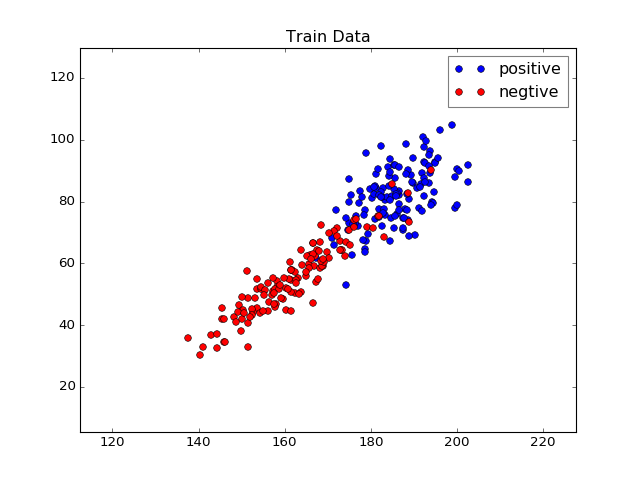

In [134]:
# plotting
fig = plt.figure()
axs = fig.add_subplot(111)

# limits for the axes
X_ = np.vstack((x, y))  # only the measurements; data is col-wise
xmin, ymin = X_.min(axis=1)
xmax, ymax = X_.max(axis=1)

xlim = [xmin-25, xmax+25]  # purely for looks
ylim = [ymin-25, ymax+25]

plt_rex.plot2d(X_pos, colwise_data=True, hatch='bo', x_lim=xlim, y_lim=ylim, 
              show=False, axs=axs, set_aspect_equal=False, plotlabel="positive")
plt_rex.plot2d(X_neg, colwise_data=True, hatch='ro', x_lim=xlim, 
               y_lim=ylim, show=False, axs=axs, set_aspect_equal=False, 
               plotlabel="negtive", title="Train Data")

#### Test on our nearest neighbor functions

In [135]:
q = np.array([170, 66])
ind = knn_rex.nearest_neighbor_method0(X_,q)
print(ind)

101


#### Use this to lable the Test data

#### First read the Test data

In [136]:
dt = np.dtype([('x', np.float), ('y', np.float), ('lable', np.float)])  # g is byte-string

data = np.loadtxt('data/data2-test.dat', dtype=dt, comments='#', delimiter=None)

x_t = np.array([d[0] for d in data])#x
y_t = np.array([d[1] for d in data])#y
lable_t = np.array([d[2] for d in data])#label

X_t = np.vstack((x_t, y_t, lable_t))  # data is going to be column-wise
X_t.shape

# split
X_t_pos, X_t_neg = pre_rex.split_data(X_t, True, 2, [1.0, -1.0])
print("Positive :", X_t_pos.shape[1], "; Negative :", X_t_neg.shape[1])

Positive : 48 ; Negative : 48


#### Plot the Test data

<IPython.core.display.Javascript object>


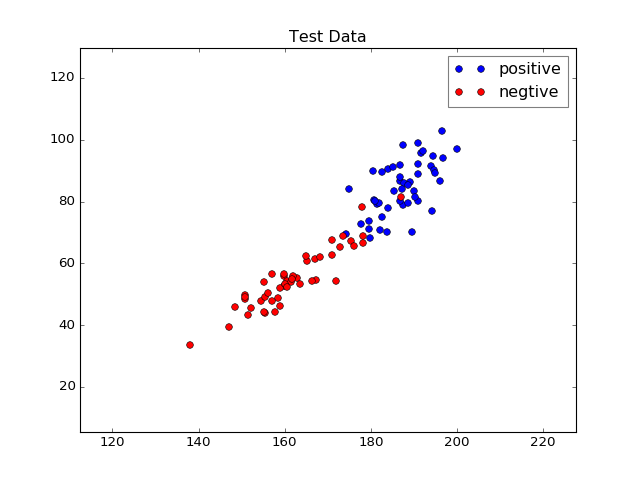

In [137]:
# plotting
fig = plt.figure()
axs = fig.add_subplot(111)

# limits for the axes
X_t_ = np.vstack((x, y))  # only the measurements; data is col-wise
xmin, ymin = X_t_.min(axis=1)
xmax, ymax = X_t_.max(axis=1)

xlim = [xmin-25, xmax+25]  # purely for looks
ylim = [ymin-25, ymax+25]

plt_rex.plot2d(X_t_pos, colwise_data=True, hatch='bo', x_lim=xlim, y_lim=ylim, 
              show=False, axs=axs, set_aspect_equal=False, plotlabel="positive")
plt_rex.plot2d(X_t_neg, colwise_data=True, hatch='ro', x_lim=xlim, 
               y_lim=ylim, show=False, axs=axs, set_aspect_equal=False, 
               plotlabel="negtive", title="Test Data")

#### Use the nearest neighbor from Train Data to predict
- First write a test function to test 3 differnet implementations
    + Method 0: Run the nearest neighbor k times, for small k
    + Method 1: Use the method from Pr's paper
    + Method 2: Adoption based on Pr's paper, instead of all members, we sort partially

In [145]:
def k_nearest_neighbors_smallk(X, q, k):
    inds=nearest_neighbor_method3(X, q)
    a_inds = np.array(inds)
    X=np.delete(X, inds, axis=1)
    for i in range(k-1):
        inds=nearest_neighbor_method2(X, q)
        a_inds=np.append(a_inds,inds)#remember to assign a pointer to new array. the return value is a pointer
        if i!=k-1:
            X=np.delete(X, inds, axis=1)
    return a_inds

def k_nearest_neighbors(X, q, k):
    X = X.T
    sorted_inds = np.argsort(np.sum((X - q)**2, axis=1))
    return sorted_inds[:k]

def k_nearest_neighbors_par(X, q, k):
    X=X.T
    sorted_inds = np.argpartition(np.sum((X - q)**2, axis=1), k-1)
    return sorted_inds[:k]

In [138]:
def recoAccurKNN(train, test, k, method):
    hit=0
    for i in range(test.shape[1]):
        if method==0:
            inds = knn_rex.k_nearest_neighbors_smallk(train[0:2,:],test[0:2,i],k)
        elif method==1:
            inds = knn_rex.k_nearest_neighbors(train[0:2,:],test[0:2,i],k)
        elif method==2:
            inds = knn_rex.k_nearest_neighbors_par(train[0:2,:],test[0:2,i],k)
        if np.multiply(np.sum(train[2,inds]),test[2,i])>0:#if the KNN votes is the same sign as lable on test data.
            hit+=1
    return (hit/test.shape[1])

#### Experiment 2.4.1
- Run the Accuracy Test on k = 1,3,5
- Test with 3 methods
- Record the time

In [139]:
i=1
while i <=5:
    for j in range(3):
        start = timeit.default_timer()
#         for k in range(2):
        reco = recoAccurKNN(X,X_t,i,j)
        stop = timeit.default_timer()
        print("Accuracy on k =",i,", method =",j,":","{0:.4f}".format(reco)," Time:",stop-start)
    i=i+2

Accuracy on k = 1 , method = 0 : 0.8854  Time: 0.011309641995467246
Accuracy on k = 1 , method = 1 : 0.8854  Time: 0.004396276955958456
Accuracy on k = 1 , method = 2 : 0.8854  Time: 0.002566142997238785
Accuracy on k = 3 , method = 0 : 0.8958  Time: 0.022450160002335906
Accuracy on k = 3 , method = 1 : 0.8958  Time: 0.005783114000223577
Accuracy on k = 3 , method = 2 : 0.8958  Time: 0.004499032045714557
Accuracy on k = 5 , method = 0 : 0.9375  Time: 0.029290897015016526
Accuracy on k = 5 , method = 1 : 0.9375  Time: 0.005974338972009718
Accuracy on k = 5 , method = 2 : 0.9375  Time: 0.005844525003340095


#### Discussion 2.4.1
- In which we can see that method 2 and 3 are nearly good.
- Then we run this test with higher K on method 2 and 3.
- And to get a stable result we repeat 10 times on both method

#### Experiment 2.4.2
- We run the experiments 100 times on method 2 and 3
- Test with small K up to 25

In [159]:
i=1
repeat = 100
while i <=25:
    for j in range(1,3):
        start = timeit.default_timer()
        for k in range(repeat):
            reco = recoAccurKNN(X,X_t,i,j)
        stop = timeit.default_timer()
        print("Accuracy on k =",i,", method =",j,":","{0:.4f}".format(reco)," Time:",stop-start)
    i=i+2

Accuracy on k = 1 , method = 1 : 0.8854  Time: 0.39151309500448406
Accuracy on k = 1 , method = 2 : 0.8854  Time: 0.2924371350090951
Accuracy on k = 3 , method = 1 : 0.8958  Time: 0.40610626398120075
Accuracy on k = 3 , method = 2 : 0.8958  Time: 0.31429312902037054
Accuracy on k = 5 , method = 1 : 0.9375  Time: 0.38827933999709785
Accuracy on k = 5 , method = 2 : 0.9375  Time: 0.3155234130099416
Accuracy on k = 7 , method = 1 : 0.9167  Time: 0.4812365690013394
Accuracy on k = 7 , method = 2 : 0.9167  Time: 0.31124918803106993
Accuracy on k = 9 , method = 1 : 0.9271  Time: 0.4919955770019442
Accuracy on k = 9 , method = 2 : 0.9271  Time: 0.3318301110411994
Accuracy on k = 11 , method = 1 : 0.9479  Time: 0.44127855595434085
Accuracy on k = 11 , method = 2 : 0.9479  Time: 0.31952754501253366
Accuracy on k = 13 , method = 1 : 0.9583  Time: 0.4658503429964185
Accuracy on k = 13 , method = 2 : 0.9583  Time: 0.34272156399674714
Accuracy on k = 15 , method = 1 : 0.9479  Time: 0.36926478700479

#### Discussion 2.4.2
- Averagely when K is small, Partial sort is better than sort.
- Observed that accuracy stablized at around 95%

#### Experiment 2.4.3
- Use method 3 to run k up to the limit

<IPython.core.display.Javascript object>


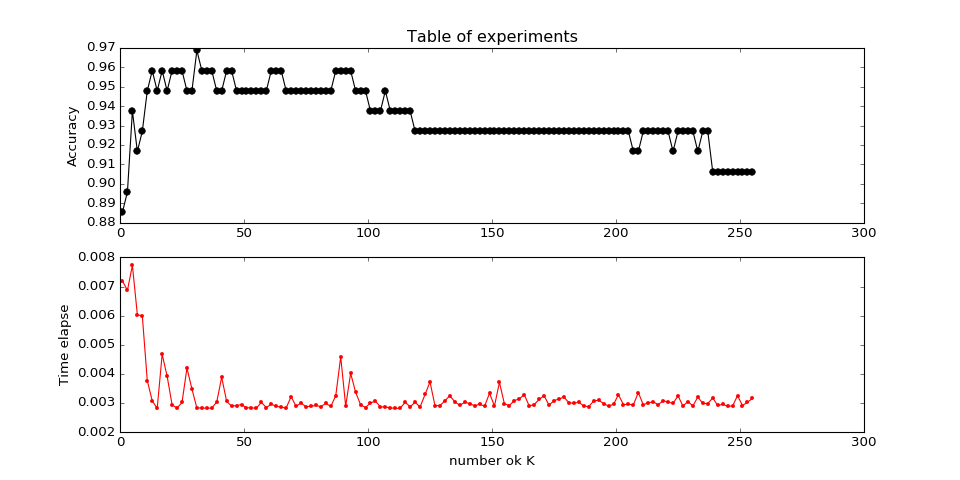

In [224]:
i=int(1)
recoList=[]
kList=[]
tList=[]
while i <=255:
    start = timeit.default_timer()
    reco = recoAccurKNN(X,X_t,i,2)
    stop = timeit.default_timer()
    recoList.append(reco)
    kList.append(i)
    tList.append(stop-start)
    i=int(i+2)
    
fig = plt.figure(figsize=(12, 6))
kArr=np.asarray(kList)
recoArr=np.asarray(recoList)
tArr=np.asarray(tList)

plt.subplot(2, 1, 1)
plt.plot(kArr, recoArr, 'ko-')
plt.title('Table of experiments')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(kArr, tArr, 'r.-')
plt.xlabel('number ok K')
plt.ylabel('Time elapse')

plt.show()

### Plot together
- We plot the prediction result and the real result together
- The Blue circle (0) represents data with label 1
- The Red star (*) represents data label -1
- The Yellow circle (0) represents data with label 1, with prediction fail
- The Yellow star (*) represents data label -1, with prediction fail

In [141]:
def preparePlotKNN(train, test, k):
    ret = np.copy(test)
    for i in range(test.shape[1]):
        inds = knn_rex.k_nearest_neighbors_par(train[0:2,:],test[0:2,i],k)
        if np.multiply(np.sum(train[2,inds]),test[2,i])< 0:#if the KNN votes is not the same sign as lable on test data.
            if(test[2,i]<0):
                ret[2,i]=-2 #-2, -1 is judged as 1
            else:
                ret[2,i]=2
    return ret

<IPython.core.display.Javascript object>


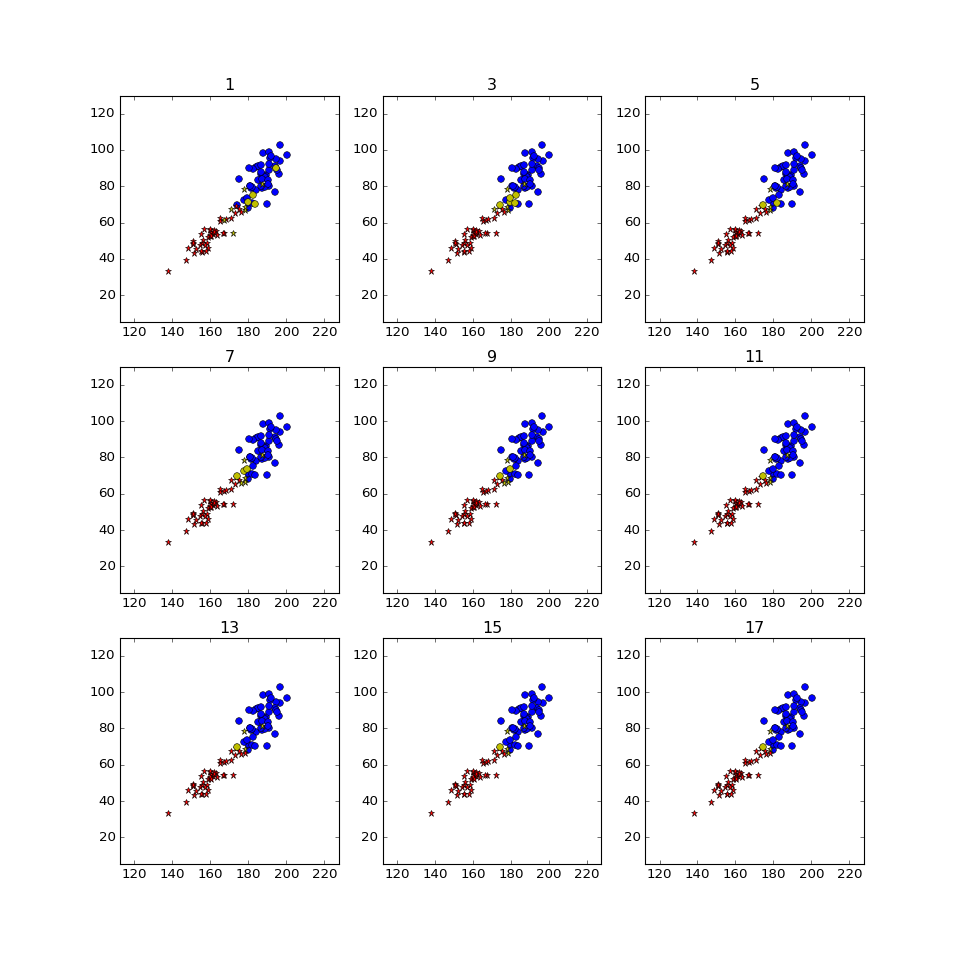

In [226]:
# plotting
fig = plt.figure(figsize=(12, 12))

# limits for the axes
xmin, ymin = X_.min(axis=1)
xmax, ymax = X_.max(axis=1)
xlim = [xmin-25, xmax+25]  # purely for looks
ylim = [ymin-25, ymax+25]

k_num = 9 # 1,3,5
KNNPlotList=[]
axsList=[]
for i in range(k_num):    
    KNNPlotList.append(preparePlotKNN(X,X_t,i*2+1))
    axsList.append(fig.add_subplot(3,3,i+1))
    Temp = pre_rex.split_data(KNNPlotList[i], True, 2, [1.0, -1.0, 2.0, -2.0])
    plt_rex.plot2d(Temp[0], colwise_data=True, hatch='bo', x_lim=xlim, y_lim=ylim, 
            show=False, axs=axsList[i], set_aspect_equal=False)
    plt_rex.plot2d(Temp[1], colwise_data=True, hatch='r*', x_lim=xlim, y_lim=ylim, 
            show=False, axs=axsList[i], set_aspect_equal=False)
    plt_rex.plot2d(Temp[2], colwise_data=True, hatch='yo', x_lim=xlim, y_lim=ylim, 
            show=False, axs=axsList[i], set_aspect_equal=False)
    plt_rex.plot2d(Temp[3], colwise_data=True, hatch='y*', x_lim=xlim, y_lim=ylim, 
            show=False, axs=axsList[i], set_aspect_equal=False, title=2*i+1)

###  2. Determin the Run Time on Nearest Neighbor

#### First define the test function
- We have 4 methods
    - Näive approch
    - From Pr's paper, use the norm
    - From Pr's paper
    - From Pr's paper

In [ ]:
def nearest_neighbor_method0(X,q):
    m, n = X.shape
    sqr = np.square(np.subtract(X.T,q))# (X-q)^2
    _sum = np.add(sqr[:,0],sqr[:,1]) #sum up the x and y
    return np.argmin(_sum) # retun the argmin

def nearest_neighbor_method1(X, q):
    m, n = X.shape
    minindx = 0
    mindist = np.inf
    for i in range(n):
        dist = la.norm(X[:,i] - q)
        if dist <= mindist:
            mindist = dist
            minindx = i
    return minindx

def nearest_neighbor_method2(X, q):
    m, n = X.shape
    return np.argmin(np.sum((X-q.reshape(m,1))**2, axis=0))

def nearest_neighbor_method3(X, q):
    X = X.T
    return np.argmin(np.sum((X - q)**2, axis=1))

In [143]:
def test1NNtime(data, method):
#     start = timeit.default_timer()
    for i in range(data.shape[1]):
        data_=np.delete(data, i, axis=1)##Delete itself
        if method==0:
            start = timeit.default_timer()
            inds = knn_rex.nearest_neighbor_method1(data_[0:2,:],data[0:2,i])
            stop = timeit.default_timer()
        elif method==1:
            start = timeit.default_timer()
            inds = knn_rex.nearest_neighbor_method1(data_[0:2,:],data[0:2,i])
            stop = timeit.default_timer()
        elif method==2:
            start = timeit.default_timer()
            inds = knn_rex.nearest_neighbor_method2(data_[0:2,:],data[0:2,i])
            stop = timeit.default_timer()
        elif method==3:
            start = timeit.default_timer()
            inds = knn_rex.nearest_neighbor_method3(data_[0:2,:],data[0:2,i])
            stop = timeit.default_timer()
#     stop = timeit.default_timer()
    return (stop-start)

In [144]:
for i in range(4):
    print("Time for method ",i, " :","{0:.15f}".format(test1NNtime(X_t,i)))

Time for method  0  : 0.000916927005164
Time for method  1  : 0.000756819965318
Time for method  2  : 0.000013878976461
Time for method  3  : 0.000029054994229


### Reference
- NumPy / SciPy Recipes for Data Science: Computing Nearest Neighbors (Christian Bauckhage, 2015)
- https://www.researchgate.net/publication/283568278_NumPy_SciPy_Recipes_for_Data_Science_Computing_Nearest_Neighbors?channel=doi&linkId=563f695508ae45b5d28d2ea9&showFulltext=true